# Non-Negative  Matrix  Factorization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.externals import joblib
from sklearn import metrics
from tqdm import tqdm

from sklearn.datasets import fetch_20newsgroups

In [2]:
docs_20 = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), random_state=74)
texts = docs_20.data

## Preprocess data

In [3]:
raw_documents = []
snippets = []
for t in texts:
    text = t.strip()
    raw_documents.append( text.lower() )
        
    snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))

Read 11314 raw text documents


In [4]:
# custom stopwords
custom_stop_words = []
with open( "stopwords.txt", "r" ) as f:
    for line in f.readlines():
        custom_stop_words.append( line.strip().lower() )
        
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


In [5]:
# create BoW + tf-idf model
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

terms = vectorizer.get_feature_names()
joblib.dump((A,terms,snippets), "articles-tfidf.pkl") 

Created 11314 X 6004 TF-IDF-normalized document-term matrix


['articles-tfidf.pkl']

In [6]:
# top features from tf-idf model
import operator


sums = np.array(A.sum(axis=0)).ravel()
# map weights to the terms
weights = { term: sums[col] for col, term in enumerate(terms)}
ranking = sorted(weights.items(), key=operator.itemgetter(1), reverse=True)
for i, pair in enumerate( ranking[0:20] ):
    print( "%s (%.2f)" % ( pair[0], pair[1] ) )

know (183.69)
get (172.95)
people (160.03)
think (156.97)
good (133.11)
thanks (133.07)
time (127.37)
please (118.39)
edu (108.17)
see (102.61)
god (101.83)
need (101.57)
way (100.23)
want (98.14)
right (97.48)
problem (95.40)
system (94.64)
windows (93.58)
something (90.52)
really (89.58)


## Apply NMF

In [7]:
(A,terms,snippets) = joblib.load( "articles-tfidf.pkl")

# create the model
k = 20
model = NMF( init="nndsvd", n_components=k ) 

W = model.fit_transform( A )
H = model.components_

In [8]:
W.shape

(11314, 20)

In [8]:
W[0,:].round(2)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [9]:
H.shape

(20, 6004)

In [10]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 20 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: good, time, see, back, really, got, go, something, thing, long, take, going, way, bike, problem, want, sure, little, work, right
Topic 02: thanks, please, mail, advance, looking, hi, email, info, address, send, post, help, information, someone, appreciated, interested, anybody, reply, list, find
Topic 03: geb, cadre, dsl, chastity, n3jxp, shameful, pitt, intellect, skepticism, surrender, gordon, banks, soon, edu, blood, patients, probably, medical, weight, disease
Topic 04: god, jesus, bible, christ, believe, faith, christian, christians, church, life, sin, truth, heaven, lord, hell, belief, man, christianity, love, father
Topic 05: key, chip, encryption, clipper, keys, escrow, system, algorithm, government, nsa, security, public, secure, phone, bit, des, encrypted, chips, secret, number
Topic 06: drive, scsi, drives, disk, hard, ide, controller, floppy, cd, mac, hd, system, boot, tape, cable, internal, rom, seagate, mb, computer
Topic 07: windows, file, dos, files, program, 

Все темы кроме 08 кажутся нормальными

In [11]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

topic_snippets = get_top_snippets( snippets, W, 0, 20 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. *******
*******  This is somewhat long, but pleas read it!!!!!!!!!!!!!!!!!
*******



Boy am i glad 
02. Accounts of Anti-Armenian Human Rights Violations in Azerbaijan #007
                 Prelude to Cur
03. Long time, no see.

			Andreas

-- 

		Andreas - Siperian Sirri   Siberian Stint
04. Accounts of Anti-Armenian Human Right Violations in Azerbaijan #008 Part A
                 Prelude 
05. Accounts of Anti-Armenian Human Right Violations in Azerbaijan #008 Part B
                 Prelude 
06. Sixteen days I had put off test driving the Honda ST1100.  Finally,
the 17th was a Saturday without 
07. Accounts of Anti-Armenian Human Right Violations in Azerbaijan #012
                 Prelude to Curr
08. Accounts of Anti-Armenian Human Right Violations in Azerbaijan #013
                 Prelude to Curr
09. I need some advice on having someone ride pillion with me on my 750 Ninja.
   This will be the the f
10. GREAT post Martin.  Very informative, well-balanced, and humanitarian
w

In [12]:
joblib.dump((W,H,terms,snippets), "articles-model-nmf-k%02d.pkl" % k) 

['articles-model-nmf-k20.pkl']

## Topic coherence

In [13]:
kmin, kmax = 4, 25

topic_models = []
for k in tqdm(range(kmin,kmax+1)):
    model = NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    topic_models.append( (k,W,H) )

100%|██████████| 22/22 [02:04<00:00,  5.67s/it]


In [14]:
import re
import gensim


class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens
            

docgen = TokenGenerator( raw_documents, custom_stop_words )
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)
print( "Model has %d terms" % len(w2v_model.wv.vocab) )
w2v_model.save("w2v-model.bin")

C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Model has 8460 terms


## TC-W2C

In [41]:
from itertools import combinations


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


k_values_TC = []
coherences_TC = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values_TC.append( k )
    coherences_TC.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences_TC[-1] ) )

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # Remove the CWD from sys.path while we load stuff.


K=04: Coherence=0.4896
K=05: Coherence=0.5074
K=06: Coherence=0.5248
K=07: Coherence=0.5378
K=08: Coherence=0.5361
K=09: Coherence=0.5452
K=10: Coherence=0.5378
K=11: Coherence=0.5502
K=12: Coherence=0.5566
K=13: Coherence=0.5592
K=14: Coherence=0.5568
K=15: Coherence=0.5564
K=16: Coherence=0.5608
K=17: Coherence=0.5520
K=18: Coherence=0.5734
K=19: Coherence=0.5659
K=20: Coherence=0.5718
K=21: Coherence=0.5814
K=22: Coherence=0.5700
K=23: Coherence=0.5656
K=24: Coherence=0.5876
K=25: Coherence=0.5739


## UCI

In [17]:
from collections import defaultdict
text_index = defaultdict(set)
for i, text in enumerate(docgen):
        for token in text:
            text_index[token].add(i)


In [18]:
kol_texts = 11314
e=10**(-12) 
#pmi=log(p(w1&w2)/p(w1)*p(w2))
def PMI (word1, word2):
    p_w1andw2 = len(text_index[word1]&text_index[word2])/kol_texts
    pmi = np.log((p_w1andw2+e)/((len(text_index[word1])/kol_texts)*(len(text_index[word2])/kol_texts)))
    return pmi

In [19]:

def C_UCI (k, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(PMI(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = (2/(len(term_rankings[topic_index])*(len(term_rankings[topic_index])-1)))*sum(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence/k


k_values_UCI = []
coherences_UCI = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values_UCI.append( k )
    coherences_UCI.append( C_UCI( k, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=1.6736
K=05: Coherence=1.7949
K=06: Coherence=1.7834
K=07: Coherence=1.7371
K=08: Coherence=1.7235
K=09: Coherence=1.7122
K=10: Coherence=1.6875
K=11: Coherence=1.7134
K=12: Coherence=1.7182
K=13: Coherence=1.7361
K=14: Coherence=1.7685
K=15: Coherence=1.7976
K=16: Coherence=1.8415
K=17: Coherence=1.7162
K=18: Coherence=1.9092
K=19: Coherence=1.7043
K=20: Coherence=1.6904
K=21: Coherence=1.7154
K=22: Coherence=1.5251
K=23: Coherence=1.7551
K=24: Coherence=1.8261
K=25: Coherence=1.6497


## UMass

In [20]:
def log_p(word1, word2):
    p_w1andw2 = len(text_index[word1]&text_index[word2])/kol_texts
    log = np.log((p_w1andw2+e)/(len(text_index[word1])/kol_texts))
    return log

In [21]:
def C_UMass (k, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(log_p(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = (2/(len(term_rankings[topic_index])*(len(term_rankings[topic_index])-1)))*sum(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence/k


k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( C_UMass( k, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=-1.7901
K=05: Coherence=-1.7679
K=06: Coherence=-1.8462
K=07: Coherence=-1.8884
K=08: Coherence=-1.8920
K=09: Coherence=-2.0094
K=10: Coherence=-2.0164
K=11: Coherence=-2.0597
K=12: Coherence=-2.0848
K=13: Coherence=-2.1058
K=14: Coherence=-2.0806
K=15: Coherence=-2.0689
K=16: Coherence=-2.0389
K=17: Coherence=-2.0678
K=18: Coherence=-1.9959
K=19: Coherence=-2.3022
K=20: Coherence=-2.2380
K=21: Coherence=-2.2848
K=22: Coherence=-2.3986
K=23: Coherence=-2.1357
K=24: Coherence=-2.1767
K=25: Coherence=-2.3180


## LDA

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.externals import joblib
from sklearn import metrics
from tqdm import tqdm

In [23]:
A,terms,snippets = joblib.load("articles-tfidf.pkl")

In [24]:
# create the model
k = 20
model_LDA = LatentDirichletAllocation(n_components=k, max_iter=5,
                                learning_method='batch',
                                learning_offset=50.,
                                random_state=1)

W = model_LDA.fit_transform( A )
H = model_LDA.components_

In [25]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 20 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: msg, food, car, helmet, think, cars, foods, chinese, good, something, time, long, eat, taste, allergic, know, get, reaction, sugar, ago
Topic 02: god, people, government, think, law, believe, christian, religion, truth, see, true, life, know, jesus, church, christians, things, right, really, way
Topic 03: card, bus, mouse, thanks, windows, drivers, vlb, driver, know, hi, video, ati, gateway, diamond, cica, ftp, isa, desktop, ram, version
Topic 04: adam, captain, israel, pov, harvard, behavior, traded, jews, das, switzerland, tonight, israeli, judaism, blacks, word, deletion, energy, agree, finland, sue
Topic 05: sale, scsi, shipping, drive, offer, price, condition, disks, 00, deleted, best, model, brand, asking, tube, sell, interested, 25, stuff, selling
Topic 06: people, armenian, war, think, armenians, time, space, know, go, turkish, president, government, islam, nasa, really, before, see, get, against, women
Topic 07: windows, thanks, know, get, system, file, program, key,

Здесь все вроде бы нормальные

In [26]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

topic_snippets = get_top_snippets( snippets, W, 0, 20 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. I've never seen a speedometer-reading model. Are you sure? Who makes
them? Consider the difficulty o
02. So, how did you guys *learn* this? Is it something you were
born with, or did you make horrible grin
03. hey... I'm pretty new to the wonderful world of motorcycles... I just
bought
a used 81 Kaw KZ650 CSR
04. I've seen a film of it, my memory may be faulty, but as I
remember it the vehicle was slightly over 
05. Apparently that last post was a little hasy, since I
called around to more places and got quotes for
06. In the Air Force world at least, the crisis escalates when scale
models of the plane in question (i.
07. Some recent postings remind me that I had read about risks 
associated with the barbecuing of foods,
08. Several years ago GM was having trouble with the rings sticking on the
5.7 diesel.  They traced a ca
09. Yeah, I'm sure that our lab would love a ride (he's the type that sticks his
head out car windows) b
10. One of those "morning, just getting the coffee in m

In [28]:
kmin, kmax = 4, 25

topic_models_LDA = []
for k in tqdm(range(kmin,kmax+1)):
    model_LDA = LatentDirichletAllocation(n_components=k, max_iter=5,
                                learning_method='batch',
                                learning_offset=50.,
                                random_state=1)
    W = model_LDA.fit_transform( A )
    H = model_LDA.components_    
    topic_models_LDA.append( (k,W,H) )


  0%|          | 0/22 [00:00<?, ?it/s]
Exception in thread Thread-27:
Traceback (most recent call last):
  File "C:\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 22/22 [11:35<00:00, 31.61s/it]


## TC-W2V

In [29]:
k_values = []
coherences = []
for (k,W,H) in topic_models_LDA:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # Remove the CWD from sys.path while we load stuff.


K=04: Coherence=0.3628
K=05: Coherence=0.3756
K=06: Coherence=0.3761
K=07: Coherence=0.4266
K=08: Coherence=0.4489
K=09: Coherence=0.4450
K=10: Coherence=0.4379
K=11: Coherence=0.4356
K=12: Coherence=0.4208
K=13: Coherence=0.4301
K=14: Coherence=0.4721
K=15: Coherence=0.4527
K=16: Coherence=0.4552
K=17: Coherence=0.4633
K=18: Coherence=0.4236
K=19: Coherence=0.4590
K=20: Coherence=0.4572
K=21: Coherence=0.4458
K=22: Coherence=0.4476
K=23: Coherence=0.4370
K=24: Coherence=0.4591
K=25: Coherence=0.4904


# UCI

In [30]:
k_values = []
coherences = []
for (k,W,H) in topic_models_LDA:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( C_UCI( k, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.5513
K=05: Coherence=0.2235
K=06: Coherence=0.1926
K=07: Coherence=0.1547
K=08: Coherence=0.0893
K=09: Coherence=-0.3922
K=10: Coherence=-0.8595
K=11: Coherence=-0.5742
K=12: Coherence=-2.0172
K=13: Coherence=-0.3151
K=14: Coherence=-0.0449
K=15: Coherence=-1.6435
K=16: Coherence=-0.4039
K=17: Coherence=-0.6589
K=18: Coherence=-1.6557
K=19: Coherence=-0.5044
K=20: Coherence=-2.1187
K=21: Coherence=-1.4054
K=22: Coherence=-1.5418
K=23: Coherence=-1.5550
K=24: Coherence=-1.6933
K=25: Coherence=-2.7008


# UMass

In [31]:
k_values = []
coherences = []
for (k,W,H) in topic_models_LDA:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( C_UMass( k, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=-2.3103
K=05: Coherence=-2.8102
K=06: Coherence=-3.0890
K=07: Coherence=-3.2976
K=08: Coherence=-3.5205
K=09: Coherence=-4.1707
K=10: Coherence=-4.6696
K=11: Coherence=-4.3995
K=12: Coherence=-6.1289
K=13: Coherence=-4.0859
K=14: Coherence=-3.9018
K=15: Coherence=-5.8684
K=16: Coherence=-4.3315
K=17: Coherence=-4.8149
K=18: Coherence=-5.6995
K=19: Coherence=-4.4619
K=20: Coherence=-6.4247
K=21: Coherence=-5.5797
K=22: Coherence=-5.7909
K=23: Coherence=-5.7011
K=24: Coherence=-5.9114
K=25: Coherence=-7.3287


# LSA

In [32]:
from sklearn.decomposition import TruncatedSVD
A,terms,snippets = joblib.load("articles-tfidf.pkl")

# create the model
k = 20
model_LSA = TruncatedSVD(n_components=k ) 

W = model_LSA.fit_transform( A )
H = model_LSA.components_

In [33]:
# show topic descriptors
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 20 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: know, people, get, think, good, time, thanks, god, please, see, want, way, need, right, system, windows, problem, edu, something, really
Topic 02: god, people, jesus, think, believe, bible, christian, christians, life, government, see, christ, faith, law, right, israel, religion, jews, fact, against
Topic 03: geb, cadre, pitt, dsl, n3jxp, chastity, shameful, edu, intellect, skepticism, surrender, gordon, banks, soon, get, team, game, key, probably, car
Topic 04: god, jesus, edu, thanks, geb, cadre, dsl, n3jxp, chastity, skepticism, shameful, intellect, pitt, gordon, surrender, banks, windows, soon, please, bible
Topic 05: key, chip, encryption, government, clipper, keys, file, public, program, law, escrow, information, windows, algorithm, files, people, security, system, window, nsa
Topic 06: drive, scsi, system, key, disk, card, drives, chip, ide, hard, controller, god, bus, floppy, problem, bit, dos, encryption, clipper, apple
Topic 07: windows, file, window, dos, files, pr

Вроде бы всё нормальное

In [35]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

topic_snippets = get_top_snippets( snippets, W, 0, 20 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. Accounts of Anti-Armenian Human Rights Violations in Azerbaijan #007
                 Prelude to Cur
02. Accounts of Anti-Armenian Human Right Violations in Azerbaijan #008 Part B
                 Prelude 
03. Accounts of Anti-Armenian Human Right Violations in Azerbaijan #012
                 Prelude to Curr
04. *******
*******  This is somewhat long, but pleas read it!!!!!!!!!!!!!!!!!
*******



Boy am i glad 
05. I am not an expert in the cryptography science, but some basic things
seem evident to me, things whi
06. Archive-name: graphics/resources-list/part3
Last-modified: 1993/04/17


Computer Graphics Resource L
07. THE WHITE HOUSE

                    Office of the Press Secretary
_________________________________
08. GREAT post Martin.  Very informative, well-balanced, and humanitarian
without neglecting the need fo
09. Accounts of Anti-Armenian Human Right Violations in Azerbaijan #008 Part A
                 Prelude 
10. Accounts of Anti-Armenian Human Right Violations in

In [37]:
kmin, kmax = 4, 25

topic_models_LSA = []
for k in tqdm(range(kmin,kmax+1)):
    model_LSA = TruncatedSVD(n_components=k ) 
    W = model_LSA.fit_transform( A )
    H = model_LSA.components_    
    topic_models_LSA.append( (k,W,H) )

100%|██████████| 22/22 [00:09<00:00,  2.26it/s]


# TC-W2V

In [38]:
k_values = []
coherences = []
for (k,W,H) in topic_models_LSA:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  # Remove the CWD from sys.path while we load stuff.


K=04: Coherence=0.4570
K=05: Coherence=0.4477
K=06: Coherence=0.4448
K=07: Coherence=0.4459
K=08: Coherence=0.4251
K=09: Coherence=0.4205
K=10: Coherence=0.4104
K=11: Coherence=0.4201
K=12: Coherence=0.4120
K=13: Coherence=0.4051
K=14: Coherence=0.3988
K=15: Coherence=0.4031
K=16: Coherence=0.3863
K=17: Coherence=0.4020
K=18: Coherence=0.3875
K=19: Coherence=0.3753
K=20: Coherence=0.3634
K=21: Coherence=0.3703
K=22: Coherence=0.3665
K=23: Coherence=0.3688
K=24: Coherence=0.3677
K=25: Coherence=0.3619


# UCI

In [39]:
k_values = []
coherences = []
for (k,W,H) in topic_models_LSA:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( C_UCI( k, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=-0.0416
K=05: Coherence=0.4171
K=06: Coherence=0.2203
K=07: Coherence=0.3439
K=08: Coherence=0.3578
K=09: Coherence=0.2518
K=10: Coherence=0.2019
K=11: Coherence=0.1800
K=12: Coherence=0.2567
K=13: Coherence=0.2335
K=14: Coherence=0.0831
K=15: Coherence=0.2466
K=16: Coherence=0.0191
K=17: Coherence=0.3055
K=18: Coherence=0.0278
K=19: Coherence=0.0146
K=20: Coherence=-0.1050
K=21: Coherence=-0.1524
K=22: Coherence=0.0650
K=23: Coherence=-0.0515
K=24: Coherence=0.1157
K=25: Coherence=-0.0663


# UMass

In [40]:
k_values = []
coherences = []
for (k,W,H) in topic_models_LSA:
    # Get all of the topic descriptors - the term_rankings, based on top 20 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 20 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( C_UMass( k, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=-3.4338
K=05: Coherence=-2.9857
K=06: Coherence=-3.2409
K=07: Coherence=-3.1335
K=08: Coherence=-3.1244
K=09: Coherence=-3.2838
K=10: Coherence=-3.3239
K=11: Coherence=-3.3794
K=12: Coherence=-3.3317
K=13: Coherence=-3.3424
K=14: Coherence=-3.5213
K=15: Coherence=-3.3453
K=16: Coherence=-3.5345
K=17: Coherence=-3.2622
K=18: Coherence=-3.5987
K=19: Coherence=-3.5137
K=20: Coherence=-3.6215
K=21: Coherence=-3.7458
K=22: Coherence=-3.4668
K=23: Coherence=-3.6273
K=24: Coherence=-3.4355
K=25: Coherence=-3.6392


# 3 best

NMF 

TC-W2V: K=24: Coherence=0.5876 |
UCI: K=18: Coherence=1.9092 |
Umass: K=05: Coherence=-1.7679 

LDA

TC-W2V: K=25: Coherence=0.4904 |
UCI: K=04: Coherence=0.5513 |
Umass: K=04: Coherence=-2.3103 


LSA

TC-W2V: K=04: Coherence=0.4570 |
UCI: K=05: Coherence=0.4171 |
Umass: K=05: Coherence=-2.9857

Самая лучшая по всем метрикам - NMF

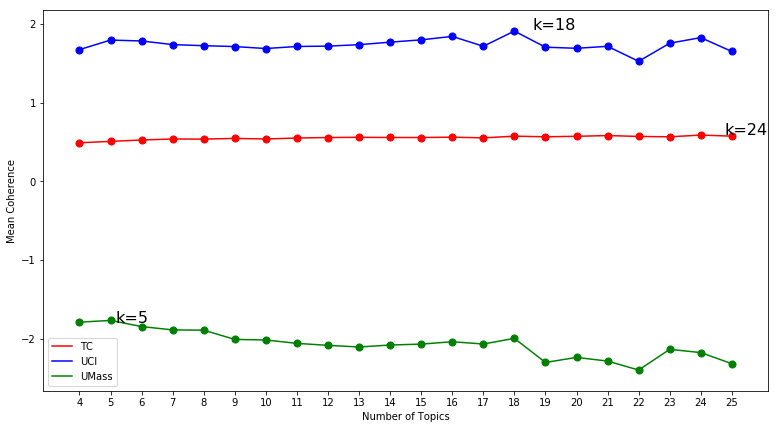

In [49]:
fig = plt.figure(figsize=(13,7))
# create the line plot
plt.plot( k_values_TC, coherences_TC, 'r', label = 'TC' )
plt.plot( k_values_UCI, coherences_UCI, 'b', label = 'UCI' )
plt.plot( k_values_UMass, coherences_UMass, 'g', label = 'UMass' )
plt.xticks(k_values_TC)
plt.xticks(k_values_UMass)
plt.xticks(k_values_UCI)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values_UMass, coherences_UMass, s=50, color ='g')
plt.scatter( k_values_TC, coherences_TC, s=50, color ='r')
plt.scatter( k_values_UCI, coherences_UCI, s=50, color ='b')
# find and annotate the maximum point on the plot
ymax = max(coherences_TC)
ymax2 = max(coherences_UCI)
ymax3 = max(coherences_UMass)
xpos1 = coherences_TC.index(ymax)
xpos2 = coherences_UCI.index(ymax2)
xpos3 = coherences_UMass.index(ymax3)
best_k1 = k_values_TC[xpos1]
best_k2 = k_values_UCI[xpos2]
best_k3 = k_values_UMass[xpos3]
plt.annotate( "k=%d" % best_k1, xy=(best_k1, ymax), xytext=(best_k1, ymax), textcoords="offset points", fontsize=16)
plt.annotate( "k=%d" % best_k2, xy=(best_k2, ymax2), xytext=(best_k2, ymax2), textcoords="offset points", fontsize=16)
plt.annotate( "k=%d" % best_k3, xy=(best_k3, ymax3), xytext=(best_k3, ymax3), textcoords="offset points", fontsize=16)
plt.legend()
# show the plot
plt.show()

TC

In [82]:
W_TC = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]
for topic_index in range(best_k1):
    descriptor = get_descriptor( terms, H, topic_index, 20 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: good, time, see, really, back, go, got, something, thing, going, take, long, bike, want, way, sure, right, little, stuff, things
Topic 02: thanks, advance, hi, info, looking, help, appreciated, anybody, information, find, appreciate, wondering, greatly, someone, lot, ftp, graphics, site, hello, software
Topic 03: geb, cadre, dsl, n3jxp, chastity, shameful, pitt, intellect, skepticism, surrender, gordon, banks, soon, edu, blood, patients, probably, medical, weight, disease
Topic 04: god, jesus, bible, christ, believe, faith, christian, christians, church, life, sin, truth, heaven, lord, hell, belief, man, christianity, love, father
Topic 05: key, chip, encryption, clipper, keys, escrow, algorithm, government, public, nsa, security, secure, phone, des, bit, encrypted, secret, chips, number, privacy
Topic 06: drive, drives, disk, hard, floppy, cd, ide, boot, controller, internal, cable, rom, hd, switch, tape, power, external, format, disks, computer
Topic 07: windows, file, dos,

UCI

In [51]:
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]
for topic_index in range(best_k2):
    descriptor = get_descriptor( terms, H, topic_index, 20 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )    


Topic 01: good, time, see, really, back, go, got, something, thing, going, take, long, bike, want, way, sure, right, little, stuff, things
Topic 02: thanks, advance, hi, info, looking, help, appreciated, anybody, information, find, appreciate, wondering, greatly, someone, lot, ftp, graphics, site, hello, software
Topic 03: geb, cadre, dsl, n3jxp, chastity, shameful, pitt, intellect, skepticism, surrender, gordon, banks, soon, edu, blood, patients, probably, medical, weight, disease
Topic 04: god, jesus, bible, christ, believe, faith, christian, christians, church, life, sin, truth, heaven, lord, hell, belief, man, christianity, love, father
Topic 05: key, chip, encryption, clipper, keys, escrow, algorithm, government, public, nsa, security, secure, phone, des, bit, encrypted, secret, chips, number, privacy
Topic 06: drive, drives, disk, hard, floppy, cd, ide, boot, controller, internal, cable, rom, hd, switch, tape, power, external, format, disks, computer
Topic 07: windows, file, dos,

UMass

In [52]:
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]
for topic_index in range(best_k3):
    descriptor = get_descriptor( terms, H, topic_index, 20 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: good, time, see, really, back, go, got, something, thing, going, take, long, bike, want, way, sure, right, little, stuff, things
Topic 02: thanks, advance, hi, info, looking, help, appreciated, anybody, information, find, appreciate, wondering, greatly, someone, lot, ftp, graphics, site, hello, software
Topic 03: geb, cadre, dsl, n3jxp, chastity, shameful, pitt, intellect, skepticism, surrender, gordon, banks, soon, edu, blood, patients, probably, medical, weight, disease
Topic 04: god, jesus, bible, christ, believe, faith, christian, christians, church, life, sin, truth, heaven, lord, hell, belief, man, christianity, love, father
Topic 05: key, chip, encryption, clipper, keys, escrow, algorithm, government, public, nsa, security, secure, phone, des, bit, encrypted, secret, chips, number, privacy


Самое лучшее у ТС

# Reccomendation

In [92]:
from sklearn.neighbors import NearestNeighbors


In [93]:
class NewsRecommender:
    def __init__(self, stopwords=custom_stop_words):
        self.texts=texts
        self.stopwords = stopwords
        self.vectorizer = TfidfVectorizer(min_df=20, stop_words=self.stopwords)
        self.nearn = NearestNeighbors(metric='cosine')
        self.model = NMF(init="nndsvd", n_components=24, random_state=74)

    def train(self, texts):
        A = self.vectorizer.fit_transform(self.texts)
        W = self.model.fit_transform(A)
        self.nearn.fit(W)
    
    def recommend(self, text_sample, k):
        news = []
        vect = self.vectorizer.transform([text_sample.lower()])
        nmf = self.model.transform(vect)
        texts_ids = self.nearn.kneighbors(nmf)[1][0]
        for i in texts_ids:
            news.append(raw_documents[i])
        return news

In [94]:
r = NewsRecommender()
r.train(raw_documents)

Тестовый текст из изначального набора текстов, которые были загружены в начале. Текст про религию и большинство из рекомендованных как-то связаны с темой религии.

In [96]:
res = r.recommend(raw_documents[5], 4)
for j in res:
    print(j)
    print('-----------------------')

slight semantical difference.  the lds church does own a heck of
a lot however.  they are the largest land holder in missouri
(where they think christ will appear at the second coming).
-----------------------
for example, if it were instinctive not to murder...


so, only intelligent beings can be moral, even if the bahavior of other
beings mimics theirs?  and, how much emphasis do you place on intelligence?
animals of the same species could kill each other arbitarily, but they
don't.  are you trying to say that this isn't an act of morality because
most animals aren't intelligent enough to think like we do?
-----------------------
i don't think such tools exist either. in addition, there's no such
thing as objective information. all together, it looks like religion
and any doctrines could be freely misused to whatever purpose.

this all reminds me of descartes' whispering deamon. you can't trust
anything. so why bother.

cheers,
kent
-----------------------
well, this is alt.atheism.

Теперь текст из  из bbc news за 2017 год

In [104]:

bbc_news = 'The year 2017 saw a burst of optimism among American investors and consumers, despite the turmoil sparked by President Trumps first year in office.The President strode from one political storm to the next as he took an axe to many of the policies of the Obama administration, but - on the economic front - the waters could hardly have been smoother.Annual economic growth has been a healthy 3% while the United States stock market is up around 25% on the year.It is true that the dollar is down roughly 10%, which makes the real rise in share prices a little less impressive, but the improved confidence of many Americans is impossible to deny.According to the US economist Irwin Stelzer of the Hudson Institute, it is the low unemployment rate of 4.1% that is the key factor.There are six million unfilled jobs in the United States at the moment, he says.'





In [106]:
res2 = r.recommend(bbc_news, 4)
for j2 in res2:
    print(j2)
    print('-----------------------')

>finally, because there is essentially no possibility of intercepting in
   >realtime the scrutable content of communications between stolen instruments,
   >there will exist strong motivation to record and archive _all_ communications
   >in the network for ex-post-facto scrutiny (once some criminal act is
   >discovered, and the instruments involved have been identified).

"all" is a *very* big number.  the at&t long distance network has
around 20,000 t3 trunks (45 mbit/sec), which is on the order of 10**12 bits/sec.
that doesn't even count the amount of traffic in the local phone companies,
or our long-distance competitors.  it's about 200 exabytes tapes / second,
which is pretty large even for the nsa :-)

on the other hand, i can easily see them recording the traffic for
"interesting" people, such as dissidents, suspected criminals,
foreign telephone calls, and anybody noticed using encryption.
as ken shiriff speculates, recording encrypted traffic will probably
be judged not to b